In [3]:
import os, random, time
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import label_binarize
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Dense, MaxPooling2D
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

In [4]:
print("GPUs:", tf.config.list_physical_devices('GPU'))
seed = 42

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Transfer Learning unfreeze all for classification 6 classes

In [6]:
# Assign params
label_map_cs = {
    'clean': 0,
    'eth': 1,
    'url': 2,
    'ps': 3,
    'html': 4,
    'js': 5,
}

def get_paths_and_labels_class_task(target_dir, label_map):
    classes = ['clean', 'stego']
    paths, labels = [], []
    for cls in classes:
        folder = os.path.join(target_dir, cls)
        for file in os.listdir(folder):
            full_path = os.path.join(folder, file)
            paths.append(full_path)
            if cls == 'clean':
                labels.append(label_map['clean'])
            else:
                found = False
                for key in label_map:
                    if key != 'clean' and key in file:
                        labels.append(label_map[key])
                        found = True
                        break
                if not found:
                    raise ValueError(f"File not found: {file}")
    return paths, np.array(labels)

# mini-VGG
def build_mini_vgg(input_shape=(256,256,4)):
    m = Sequential([
        Input(shape=input_shape),
        # blok 1
        Conv2D(32,3,activation='relu',padding='same'), 
        Conv2D(32,3,activation='relu',padding='same'),
        MaxPooling2D(2),
        
        # blok 2
        Conv2D(64,3,activation='relu',padding='same'), 
        Conv2D(64,3,activation='relu',padding='same'),
        MaxPooling2D(2),
        
        # blok 3
        Conv2D(128,3,activation='relu',padding='same'), 
        Conv2D(128,3,activation='relu',padding='same'),
        MaxPooling2D(2),

        # fc
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return m

In [7]:
# create datasets
train_paths_cs, train_labels_cs = get_paths_and_labels_class_task(train_dir, label_map_cs)
val_paths_cs,   val_labels_cs   = get_paths_and_labels_class_task(val_dir, label_map_cs)
test_paths_cs, test_labels_cs = get_paths_and_labels_class_task(test_dir, label_map_cs)
base64_paths_cs, base64_labels_cs = get_paths_and_labels_class_task(base64_enc, label_map_cs)
zip_paths_cs, zip_labels_cs = get_paths_and_labels_class_task(zip_enc, label_map_cs)

train_ds_cs = (tf.data.Dataset.from_tensor_slices((train_paths_cs, train_labels_cs))
    .shuffle(len(train_paths_cs))
    .map(lambda p,l: preprocess(p,l,True), num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE)
)

val_ds_cs = (tf.data.Dataset.from_tensor_slices((val_paths_cs, val_labels_cs))
    .map(lambda p,l: preprocess(p,l,False), num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE)
)

test_ds_cs = (tf.data.Dataset.from_tensor_slices((test_paths_cs, test_labels_cs))
    .map(lambda p,l: preprocess(p,l,False), num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE)
)

base64_ds_cs = (tf.data.Dataset.from_tensor_slices((base64_paths_cs, base64_labels_cs))
    .map(lambda p,l: preprocess(p,l,False), num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE)
)

zip_ds_cs = (tf.data.Dataset.from_tensor_slices((zip_paths_cs, zip_labels_cs))
    .map(lambda p,l: preprocess(p,l,False), num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE)
)

In [8]:
# Bangun dan load pretrained binary model
model_bin = build_mini_vgg(input_shape=(256, 256, 4))
model_bin.load_weights('/kaggle/input/minivgg256/tensorflow2/default/1/mini_vgg_256_hp.keras')

# Panggil model dengan input dummy agar semua tensor terdefinisi
_ = model_bin(tf.zeros((1, 256, 256, 4)))  # now .input and .output are available

# Ambil input dan output layer sebelum klasifikasi
base_input = model_bin.layers[0].input           # Input layer
base_output = model_bin.layers[-3].output        # GlobalAveragePooling2D

# Tambahkan head baru untuk klasifikasi payload
dense1 = Dense(128, activation='relu')(base_output)
final_output = Dense(6, activation='softmax')(dense1)

# Buat model transfer learning
model_cs = Model(inputs=base_input, outputs=final_output)

# 5. Kompilasi model
model_cs.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cbs = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('mini_vgg_tl_021025.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

model_cs.summary()



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,582 (1.16 MB)

 Trainable params: 304,582 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
print("Jumlah total layer:", len(model_cs.layers))
print("Jumlah layer yang dapat dilatih:", sum([l.trainable for l in model_cs.layers]))

Jumlah total layer: 13
Jumlah layer yang dapat dilatih: 13


Epoch 1/60


I0000 00:00:1759454617.821972      79 service.cc:148] XLA service 0x7fe860002150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759454617.823001      79 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/500 ━━━━━━━━━━━━━━━━━━━━ 37s 75ms/step - accuracy: 0.0000e+00 - loss: 5.2780   

I0000 00:00:1759454627.202864      79 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.2590 - loss: 1.7877
Epoch 1: val_loss improved from inf to 0.63964, saving model to mini_vgg_tl_021025.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 115s 206ms/step - accuracy: 0.2593 - loss: 1.7869 - val_accuracy: 0.6885 - val_loss: 0.6396 - learning_rate: 1.0000e-04
Epoch 2/60
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7092 - loss: 0.6179
Epoch 2: val_loss improved from 0.63964 to 0.49909, saving model to mini_vgg_tl_021025.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 91s 181ms/step - accuracy: 0.7092 - loss: 0.6178 - val_accuracy: 0.6875 - val_loss: 0.4991 - learning_rate: 1.0000e-04
Epoch 3/60
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7381 - loss: 0.5020
Epoch 3: val_loss improved from 0.49909 to 0.43699, saving model to mini_vgg_tl_021025.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 90s 180ms/step - accuracy: 0.7381 - loss: 0.5019 - val_accuracy: 0.7691 - val_loss: 0.4370 - learning_rate: 1.0000e-04
Epoch 4/60
500/500 ━━━━━━━━

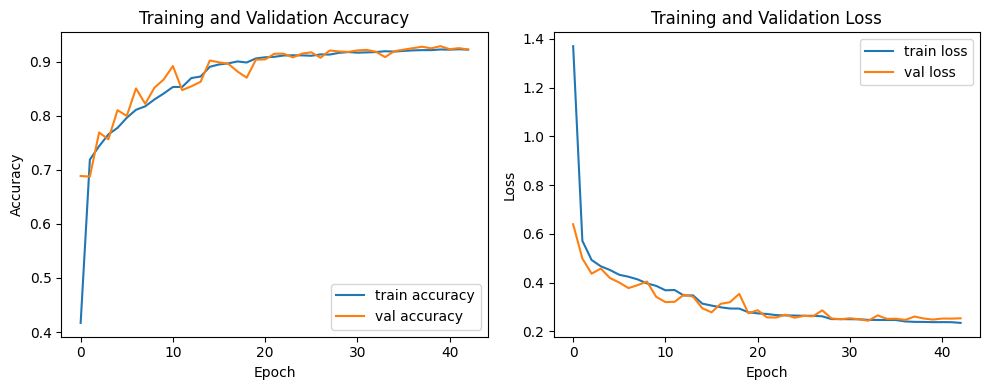

In [10]:
# Train
start_time = time.time()
history_cs = model_cs.fit(
    train_ds_cs,
    validation_data=val_ds_cs,
    epochs=60,
    callbacks=cbs
)
duration = time.time() - start_time
print(f"Training completed in {duration:.2f} seconds ({duration/60:.2f} minutes)")

# Plot Accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cs.history['accuracy'], label='train accuracy')
plt.plot(history_cs.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_cs.history['loss'], label='train loss')
plt.plot(history_cs.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Test set

In [11]:
# Load model
loaded_model_cs = load_model('/kaggle/working/mini_vgg_tl_021025.keras')

# Evaluate on test set
loss, acc = loaded_model_cs.evaluate(test_ds_cs, verbose=1)
print(f"\nTest set performance → Loss: {loss:.4f}, Accuracy: {acc:.4f}")

# Predict on test set
y_true_cs, y_probs_cs, y_pred_cs = [], [], []

for x_batch, y_batch in test_ds_cs:
    probs = loaded_model_cs.predict(x_batch, verbose=0)  
    preds = tf.argmax(probs, axis=1)             
    
    y_probs_cs.extend(probs)                        
    y_pred_cs.extend(preds.numpy().tolist())
    y_true_cs.extend(y_batch.numpy().tolist())

# Convert to numpy arrays
y_true_cs = np.array(y_true_cs)
y_pred_cs = np.array(y_pred_cs)
y_probs_cs = np.array(y_probs_cs)

250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 141ms/step - accuracy: 0.9538 - loss: 0.1404

Test set performance → Loss: 0.2529, Accuracy: 0.9151



Detailed Classification Report:


,precision,recall,f1-score,support
clean,0.999001,1.000000,0.999500,2000.000000
eth,0.808843,0.997594,0.893357,1247.000000
url,0.989418,0.757699,0.858192,1234.000000
ps,0.905660,0.989691,0.945813,1164.000000
html,0.847859,0.950300,0.896162,1167.000000
js,0.942246,0.741582,0.829958,1188.000000
accuracy,0.915125,0.915125,0.915125,0.915125
macro avg,0.915505,0.906144,0.903830,8000.000000
weighted avg,0.923825,0.915125,0.913095,8000.000000


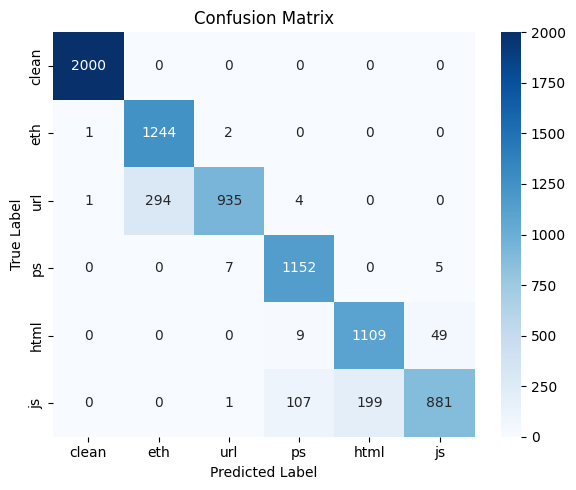

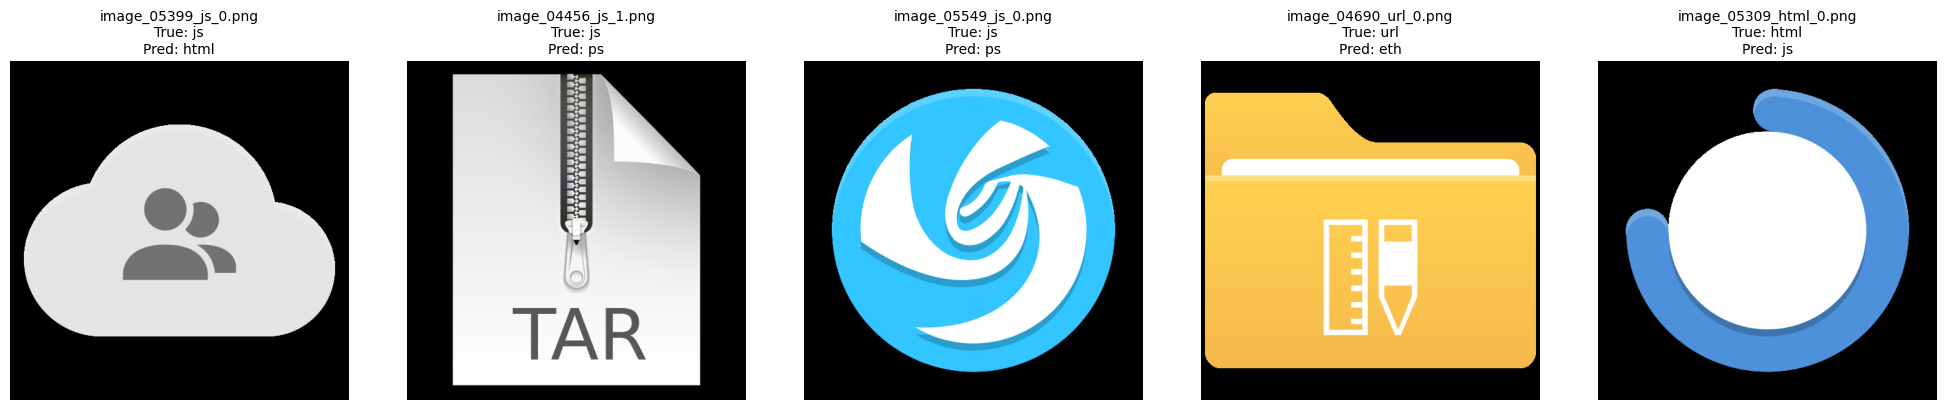

Number of failed predictions: 679


In [12]:
label_map_cs_inv = {v: k for k, v in label_map_cs.items()}

cm_cs = confusion_matrix(y_true_cs, y_pred_cs)

# Classification Report
report_dict_cs = classification_report(y_true_cs, y_pred_cs, target_names=list(label_map_cs.keys()), output_dict=True)
report_df_cs = pd.DataFrame(report_dict_cs).transpose()

print("\nDetailed Classification Report:")
display(report_df_cs)

roc_auc_cs = roc_auc_score(y_true_cs, y_probs_cs, multi_class='ovr', average='macro')

# Confusion Matrix (absolute)
plt.figure(figsize=(6,5))
sns.heatmap(cm_cs, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label_map_cs.keys()),
            yticklabels=list(label_map_cs.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Plotly bar chart
# Per-class accuracy
class_acc = cm_cs.diagonal() / cm_cs.sum(axis=1)
acc_table = pd.DataFrame({
    'Class': [label_map_cs_inv[i] for i in range(len(label_map_cs))],
    'Accuracy': class_acc
})

# Plotly bar chart
# Per-class accuracy
class_acc = cm_cs.diagonal() / cm_cs.sum(axis=1)
acc_table = pd.DataFrame({
    'Class': [label_map_cs_inv[i] for i in range(len(label_map_cs))],
    'Accuracy': class_acc
})

fig = go.Figure(data=[
    go.Bar(
        x=acc_table['Class'],
        y=acc_table['Accuracy'],
        marker_color='lightskyblue',
        text=[f"{a:.2f}" for a in acc_table['Accuracy']],
        textposition='auto'
    )
])

fig.update_layout(
    title='Per-Class Accuracy',
    xaxis_title='Class',
    yaxis_title='Accuracy',
    yaxis=dict(range=[0, 1.05]),
    template='plotly_white'
)

fig.show()

# show sample of error prediction images
num_samples_cs = 5
fig_cs, axes_cs = plt.subplots(1, num_samples_cs, figsize=(20, 4))
mis_idx_cs = [i for i, (yt, yp) in enumerate(zip(y_true_cs, y_pred_cs)) if yt != yp]

for i, idx in enumerate(mis_idx_cs[:num_samples_cs]):
    img_path = test_paths_cs[idx]
    img = plt.imread(img_path)
    filename = os.path.basename(img_path)
    
    axes_cs[i].imshow(img)
    axes_cs[i].set_title(f"{filename}\nTrue: {label_map_cs_inv[y_true_cs[idx]]}\nPred: {label_map_cs_inv[y_pred_cs[idx]]}", fontsize=10)
    axes_cs[i].axis('off')

plt.tight_layout()
plt.show()

print(f"Number of failed predictions: {len(mis_idx_cs)}")

In [13]:
accuracy_cs  = report_dict_cs["accuracy"]
precision_cs = report_dict_cs["weighted avg"]["precision"]
recall_cs    = report_dict_cs["weighted avg"]["recall"]
f1_score_cs  = report_dict_cs["weighted avg"]["f1-score"]

accuracy_cs, precision_cs, recall_cs, f1_score_cs, roc_auc_cs

(0.915125,
 0.9238249167977493,
 0.915125,
 0.9130952610178269,
 0.9876062310508845)

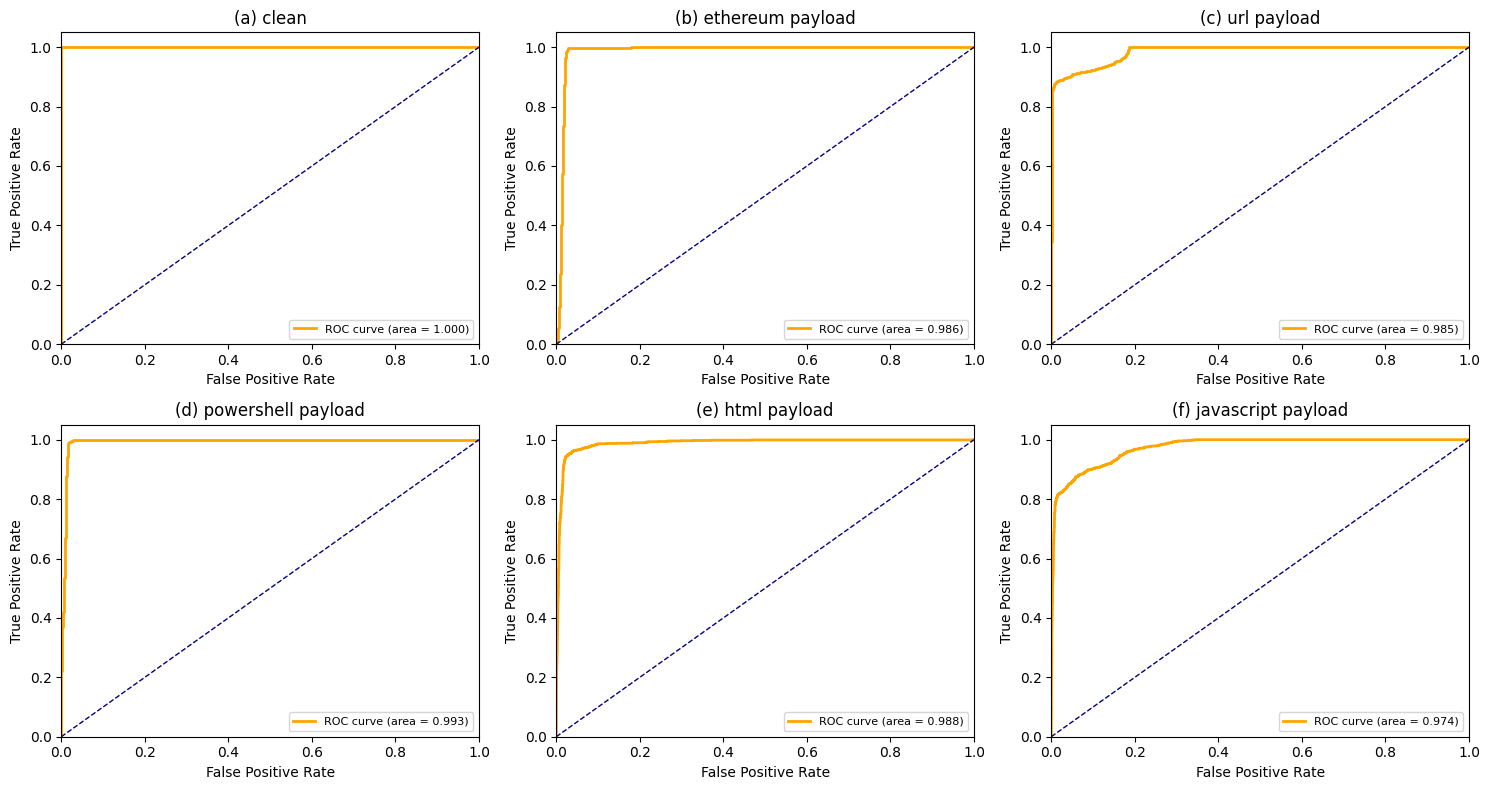

In [14]:
class_names = [
    'clean',
    'ethereum payload',
    'url payload',
    'powershell payload',
    'html payload',
    'javascript payload',
]

n_classes = len(class_names)
y_test_bin = label_binarize(y_true_cs, classes=list(range(n_classes)))

fig_cs, axes_cs = plt.subplots(2, 3, figsize=(15, 8))
axes_cs = axes_cs.ravel()

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs_cs[:, i])
    roc_auc = auc(fpr, tpr)
    axes_cs[i].plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    axes_cs[i].plot([0, 1], [0, 1], '--', color='navy', lw=1)
    axes_cs[i].set_xlim([0.0, 1.0])
    axes_cs[i].set_ylim([0.0, 1.05])
    axes_cs[i].set_xlabel('False Positive Rate')
    axes_cs[i].set_ylabel('True Positive Rate')
    axes_cs[i].set_title(f'({chr(97+i)}) {class_names[i]}')
    axes_cs[i].legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()

## Bae64 Test Set

In [15]:
# Evaluate on base64 set
loss, acc = loaded_model_cs.evaluate(base64_ds_cs, verbose=1)
print(f"\nTest set performance → Loss: {loss:.4f}, Accuracy: {acc:.4f}")

# Predict on base64 set
y_true_cs, y_probs_cs, y_pred_cs = [], [], []

for x_batch, y_batch in base64_ds_cs:
    probs = loaded_model_cs.predict(x_batch, verbose=0)  
    preds = tf.argmax(probs, axis=1)             
    
    y_probs_cs.extend(probs)                        
    y_pred_cs.extend(preds.numpy().tolist())
    y_true_cs.extend(y_batch.numpy().tolist())

# Convert to numpy arrays
y_true_cs = np.array(y_true_cs)
y_pred_cs = np.array(y_pred_cs)
y_probs_cs = np.array(y_probs_cs)

250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 145ms/step - accuracy: 0.8126 - loss: 0.4557

Test set performance → Loss: 0.8166, Accuracy: 0.6626



Detailed Classification Report:


,precision,recall,f1-score,support
clean,0.999001,1.000000,0.999500,2000.000000
eth,0.000000,0.000000,0.000000,1247.000000
url,0.298482,0.430308,0.352473,1234.000000
ps,0.907718,0.929553,0.918506,1164.000000
html,0.680400,0.934019,0.787288,1167.000000
js,0.798398,0.503367,0.617450,1188.000000
accuracy,0.662625,0.662625,0.662625,0.662625
macro avg,0.614000,0.632875,0.612536,8000.000000
weighted avg,0.645679,0.662625,0.644423,8000.000000


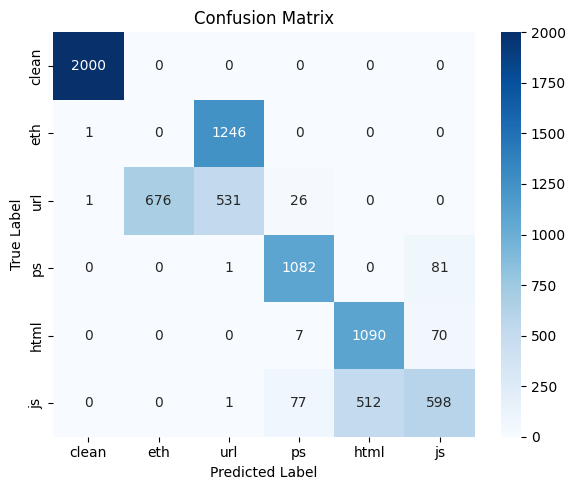

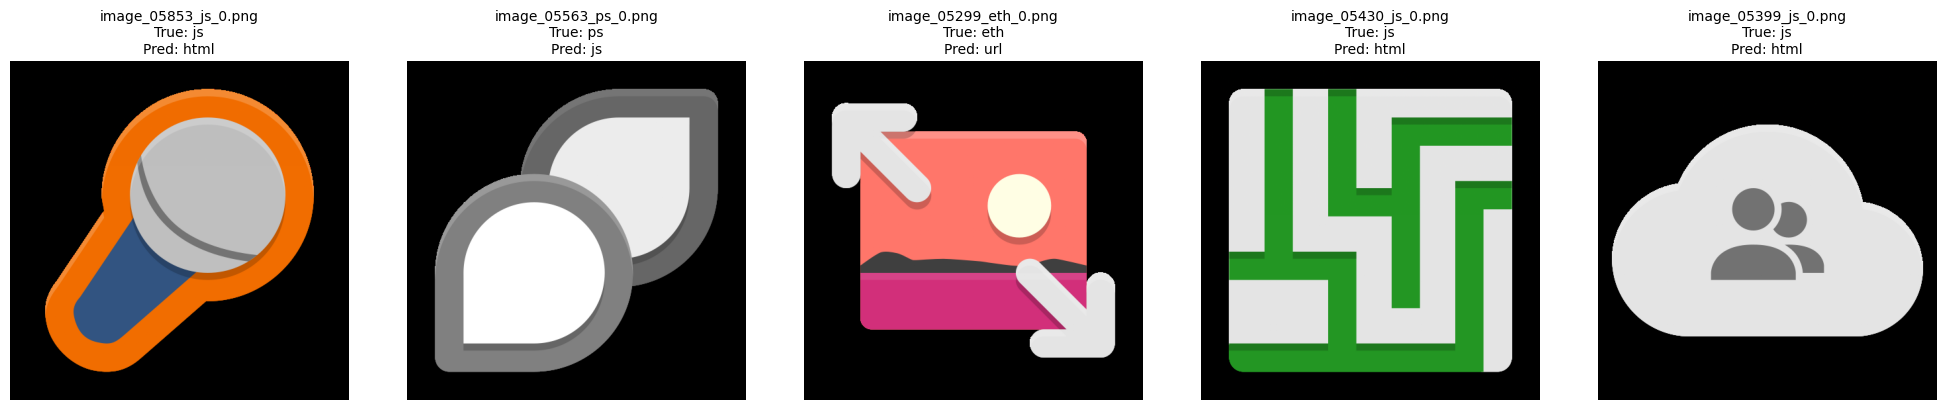

Number of failed predictions: 2699


In [16]:
#label_map_cs_inv = {v: k for k, v in label_map_cs.items()}

cm_cs = confusion_matrix(y_true_cs, y_pred_cs)

# Classification Report
report_dict_cs = classification_report(y_true_cs, y_pred_cs, target_names=list(label_map_cs.keys()), output_dict=True)
report_df_cs = pd.DataFrame(report_dict_cs).transpose()

print("\nDetailed Classification Report:")
display(report_df_cs)

roc_auc_cs = roc_auc_score(y_true_cs, y_probs_cs, multi_class='ovr', average='macro')

# Confusion Matrix (absolute)
plt.figure(figsize=(6,5))
sns.heatmap(cm_cs, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label_map_cs.keys()),
            yticklabels=list(label_map_cs.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Plotly bar chart
# Per-class accuracy
class_acc = cm_cs.diagonal() / cm_cs.sum(axis=1)
acc_table = pd.DataFrame({
    'Class': [label_map_cs_inv[i] for i in range(len(label_map_cs))],
    'Accuracy': class_acc
})

fig = go.Figure(data=[
    go.Bar(
        x=acc_table['Class'],
        y=acc_table['Accuracy'],
        marker_color='lightskyblue',
        text=[f"{a:.2f}" for a in acc_table['Accuracy']],
        textposition='auto'
    )
])

fig.update_layout(
    title='Per-Class Accuracy',
    xaxis_title='Class',
    yaxis_title='Accuracy',
    yaxis=dict(range=[0, 1.05]),
    template='plotly_white'
)

fig.show()

# show sample of error prediction images
num_samples_cs = 5
fig_cs, axes_cs = plt.subplots(1, num_samples_cs, figsize=(20, 4))
mis_idx_cs = [i for i, (yt, yp) in enumerate(zip(y_true_cs, y_pred_cs)) if yt != yp]

for i, idx in enumerate(mis_idx_cs[:num_samples_cs]):
    img_path = base64_paths_cs[idx]
    img = plt.imread(img_path)
    filename = os.path.basename(img_path)
    
    axes_cs[i].imshow(img)
    axes_cs[i].set_title(f"{filename}\nTrue: {label_map_cs_inv[y_true_cs[idx]]}\nPred: {label_map_cs_inv[y_pred_cs[idx]]}", fontsize=10)
    axes_cs[i].axis('off')

plt.tight_layout()
plt.show()

print(f"Number of failed predictions: {len(mis_idx_cs)}")

In [17]:
accuracy_cs  = report_dict_cs["accuracy"]
precision_cs = report_dict_cs["weighted avg"]["precision"]
recall_cs    = report_dict_cs["weighted avg"]["recall"]
f1_score_cs  = report_dict_cs["weighted avg"]["f1-score"]

accuracy_cs, precision_cs, recall_cs, f1_score_cs, roc_auc_cs

(0.662625,
 0.6456794900185647,
 0.662625,
 0.6444234657990633,
 0.9239328852743806)

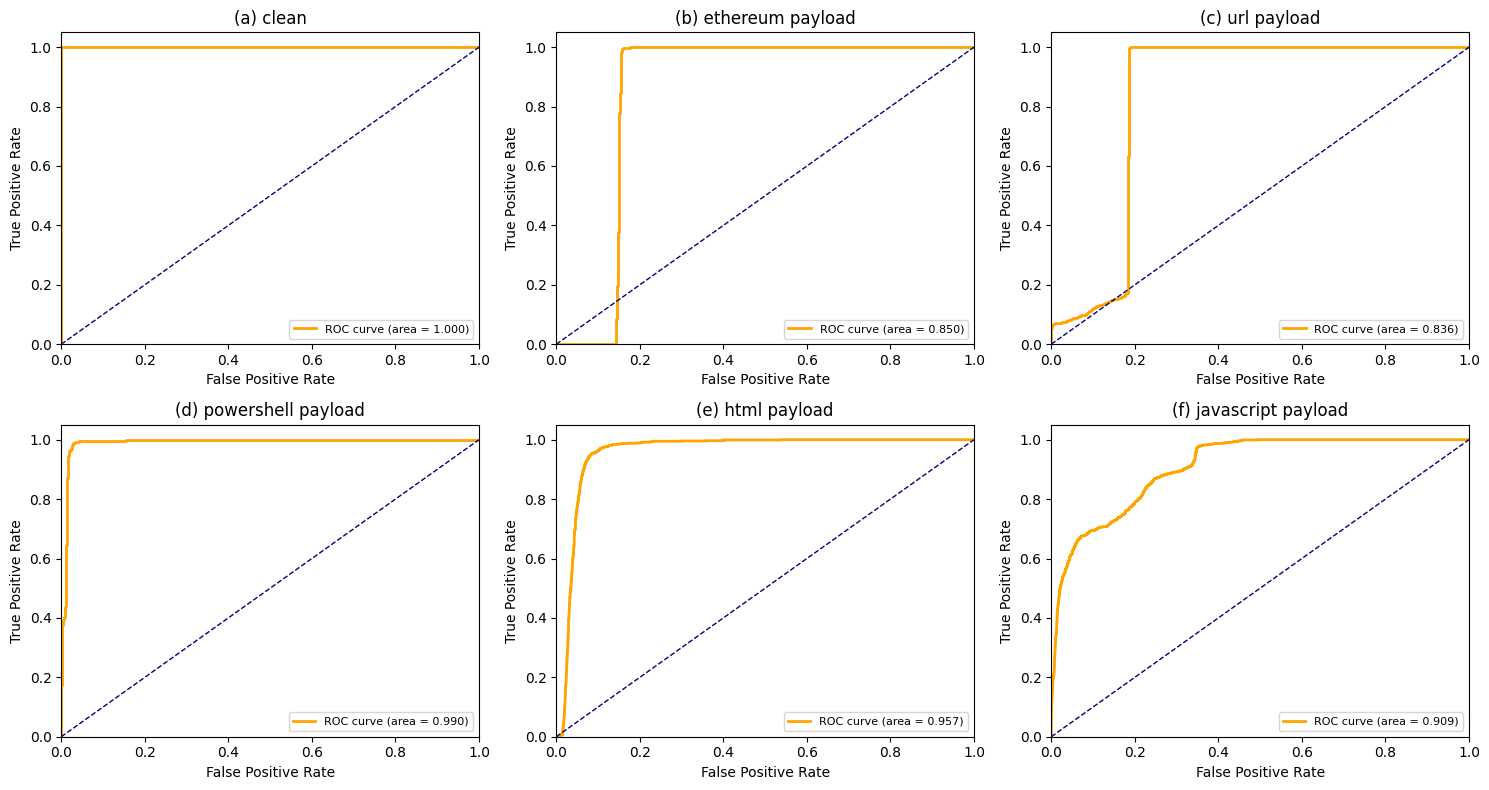

In [18]:
n_classes = len(class_names)
y_base64_bin = label_binarize(y_true_cs, classes=list(range(n_classes)))

fig_cs, axes_cs = plt.subplots(2, 3, figsize=(15, 8))
axes_cs = axes_cs.ravel()

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_base64_bin[:, i], y_probs_cs[:, i])
    roc_auc = auc(fpr, tpr)
    axes_cs[i].plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    axes_cs[i].plot([0, 1], [0, 1], '--', color='navy', lw=1)
    axes_cs[i].set_xlim([0.0, 1.0])
    axes_cs[i].set_ylim([0.0, 1.05])
    axes_cs[i].set_xlabel('False Positive Rate')
    axes_cs[i].set_ylabel('True Positive Rate')
    axes_cs[i].set_title(f'({chr(97+i)}) {class_names[i]}')
    axes_cs[i].legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()

## Zip Test Set

In [19]:
# Evaluate on zip set
loss, acc = loaded_model_cs.evaluate(zip_ds_cs, verbose=1)
print(f"\nTest set performance → Loss: {loss:.4f}, Accuracy: {acc:.4f}")

# Predict on zip set
y_true_cs, y_probs_cs, y_pred_cs = [], [], []

for x_batch, y_batch in zip_ds_cs:
    probs = loaded_model_cs.predict(x_batch, verbose=0)  
    preds = tf.argmax(probs, axis=1)             
    
    y_probs_cs.extend(probs)                        
    y_pred_cs.extend(preds.numpy().tolist())
    y_true_cs.extend(y_batch.numpy().tolist())

# Convert to numpy arrays
y_true_cs = np.array(y_true_cs)
y_pred_cs = np.array(y_pred_cs)
y_probs_cs = np.array(y_probs_cs)

250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 140ms/step - accuracy: 0.7843 - loss: 3.0981

Test set performance → Loss: 5.6608, Accuracy: 0.6016



Detailed Classification Report:


,precision,recall,f1-score,support
clean,1.000000,1.000000,1.000000,2000.000000
eth,0.000000,0.000000,0.000000,1247.000000
url,0.375000,0.002431,0.004831,1234.000000
ps,0.306737,0.997423,0.469186,1164.000000
html,0.850990,0.626392,0.721619,1167.000000
js,0.681514,0.772727,0.724260,1188.000000
accuracy,0.601625,0.601625,0.601625,0.601625
macro avg,0.535707,0.566496,0.486649,8000.000000
weighted avg,0.577817,0.601625,0.531831,8000.000000


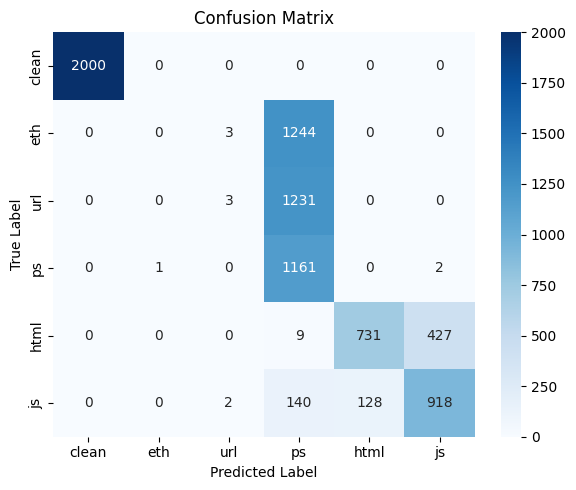

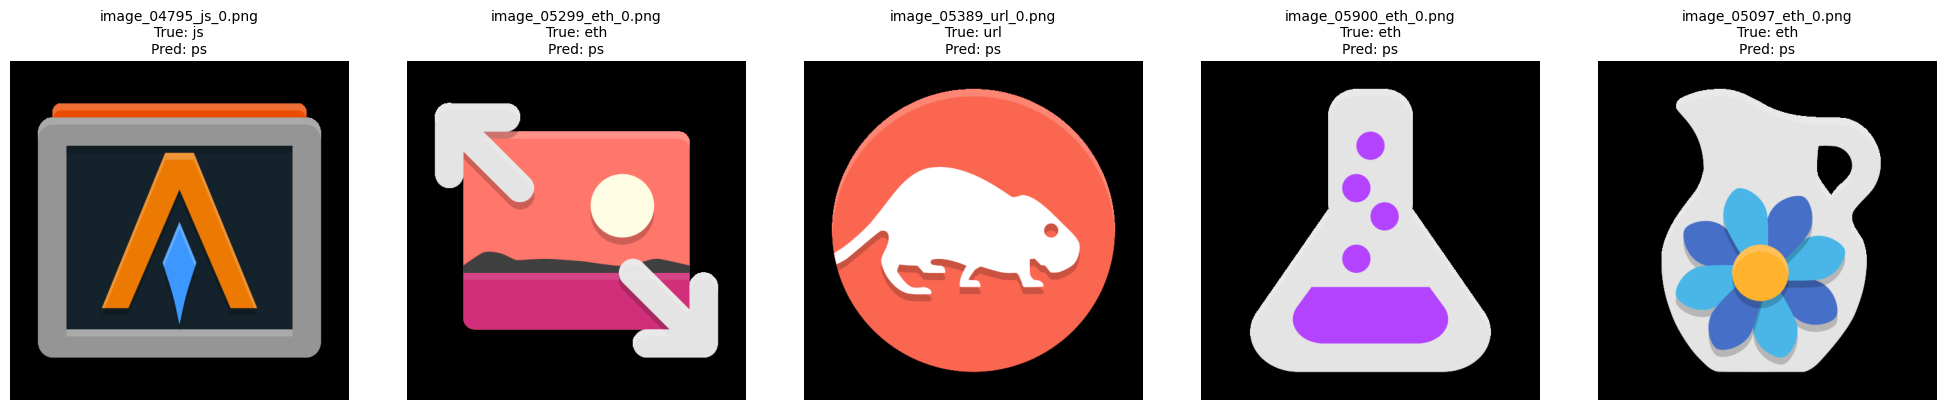

Number of failed predictions: 3187


In [20]:
#label_map_cs_inv = {v: k for k, v in label_map_cs.items()}

cm_cs = confusion_matrix(y_true_cs, y_pred_cs)

# Classification Report
report_dict_cs = classification_report(y_true_cs, y_pred_cs, target_names=list(label_map_cs.keys()), output_dict=True)
report_df_cs = pd.DataFrame(report_dict_cs).transpose()

print("\nDetailed Classification Report:")
display(report_df_cs)

roc_auc_cs = roc_auc_score(y_true_cs, y_probs_cs, multi_class='ovr', average='macro')

# Confusion Matrix (absolute)
plt.figure(figsize=(6,5))
sns.heatmap(cm_cs, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label_map_cs.keys()),
            yticklabels=list(label_map_cs.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Plotly bar chart
# Per-class accuracy
class_acc = cm_cs.diagonal() / cm_cs.sum(axis=1)
acc_table = pd.DataFrame({
    'Class': [label_map_cs_inv[i] for i in range(len(label_map_cs))],
    'Accuracy': class_acc
})

fig = go.Figure(data=[
    go.Bar(
        x=acc_table['Class'],
        y=acc_table['Accuracy'],
        marker_color='lightskyblue',
        text=[f"{a:.2f}" for a in acc_table['Accuracy']],
        textposition='auto'
    )
])

fig.update_layout(
    title='Per-Class Accuracy',
    xaxis_title='Class',
    yaxis_title='Accuracy',
    yaxis=dict(range=[0, 1.05]),
    template='plotly_white'
)

fig.show()

# show sample of error prediction images
num_samples_cs = 5
fig_cs, axes_cs = plt.subplots(1, num_samples_cs, figsize=(20, 4))
mis_idx_cs = [i for i, (yt, yp) in enumerate(zip(y_true_cs, y_pred_cs)) if yt != yp]

for i, idx in enumerate(mis_idx_cs[:num_samples_cs]):
    img_path = zip_paths_cs[idx]
    img = plt.imread(img_path)
    filename = os.path.basename(img_path)
    
    axes_cs[i].imshow(img)
    axes_cs[i].set_title(f"{filename}\nTrue: {label_map_cs_inv[y_true_cs[idx]]}\nPred: {label_map_cs_inv[y_pred_cs[idx]]}", fontsize=10)
    axes_cs[i].axis('off')

plt.tight_layout()
plt.show()

print(f"Number of failed predictions: {len(mis_idx_cs)}")

In [21]:
accuracy_cs  = report_dict_cs["accuracy"]
precision_cs = report_dict_cs["weighted avg"]["precision"]
recall_cs    = report_dict_cs["weighted avg"]["recall"]
f1_score_cs  = report_dict_cs["weighted avg"]["f1-score"]

accuracy_cs, precision_cs, recall_cs, f1_score_cs, roc_auc_cs

(0.601625,
 0.5778169973920172,
 0.601625,
 0.5318305151494636,
 0.8567232705421822)

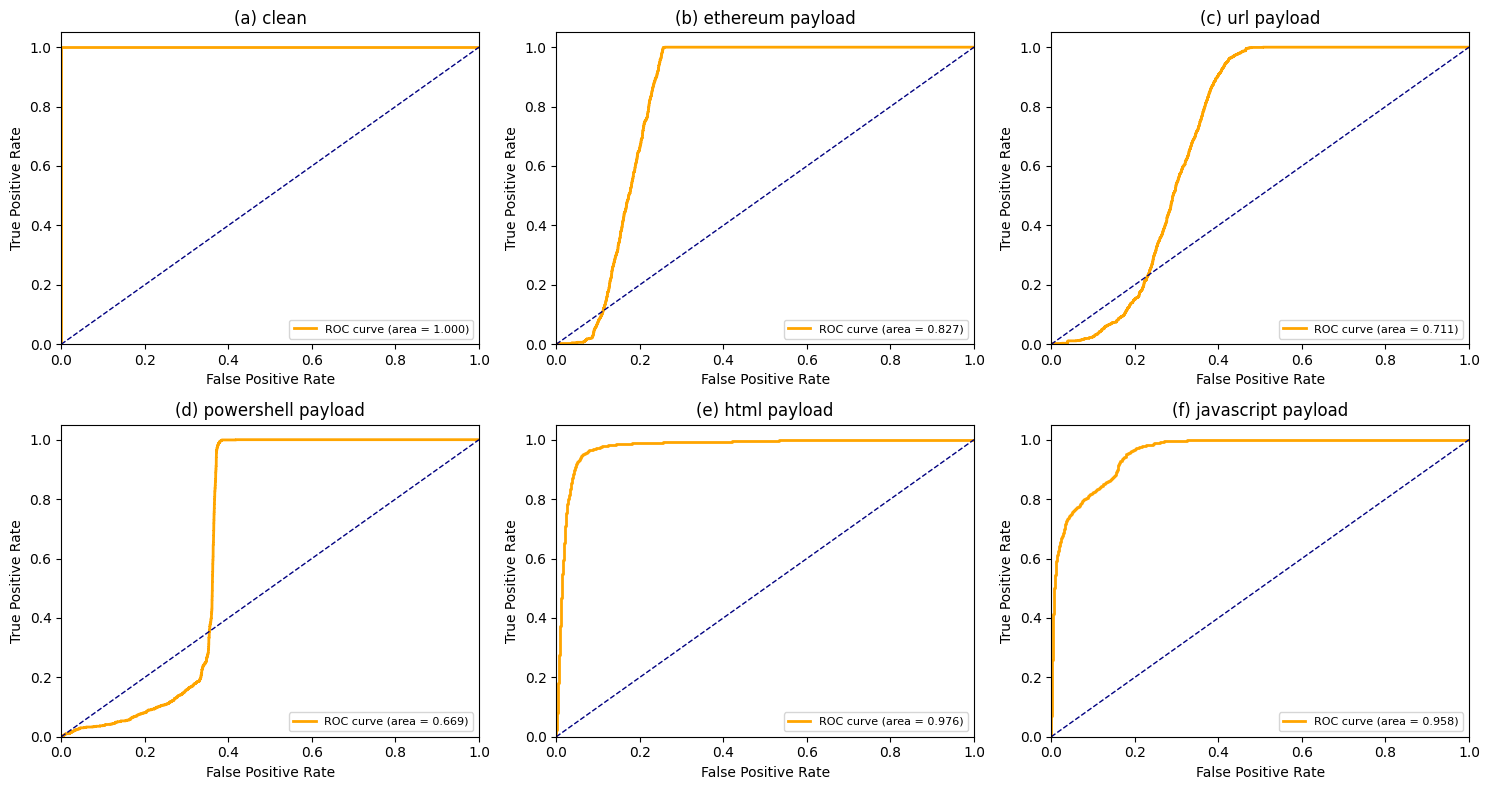

In [22]:
n_classes = len(class_names)
y_zip_bin = label_binarize(y_true_cs, classes=list(range(n_classes)))

fig_cs, axes_cs = plt.subplots(2, 3, figsize=(15, 8))
axes_cs = axes_cs.ravel()

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_zip_bin[:, i], y_probs_cs[:, i])
    roc_auc = auc(fpr, tpr)
    axes_cs[i].plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    axes_cs[i].plot([0, 1], [0, 1], '--', color='navy', lw=1)
    axes_cs[i].set_xlim([0.0, 1.0])
    axes_cs[i].set_ylim([0.0, 1.05])
    axes_cs[i].set_xlabel('False Positive Rate')
    axes_cs[i].set_ylabel('True Positive Rate')
    axes_cs[i].set_title(f'({chr(97+i)}) {class_names[i]}')
    axes_cs[i].legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()

# Transfer Learning Freeze layer ke 0-5

In [6]:
# 1. Load model hasil training binary classification
model_bin = build_mini_vgg(input_shape=(256,256,4))
model_bin.load_weights('/kaggle/input/minivgg256/tensorflow2/default/1/mini_vgg_256_hp.keras')

# 2. Panggil dummy input agar .input dan .output terbentuk
dummy_input = tf.zeros((1, 256, 256, 4))
_ = model_bin(dummy_input)

# 3. Bekukan layer Conv2D sampai conv2d_5
for layer in model_bin.layers[:8]:
    layer.trainable = False

# 4. Ambil input & output feature extractor secara aman
base_input = model_bin.layers[0].input            # input layer
base_output = model_bin.layers[-3].output         # output GlobalAveragePooling2D

# 5. Tambahkan head baru untuk klasifikasi payload
dense1 = Dense(128, activation='relu')(base_output)
final_output = Dense(6, activation='softmax')(dense1)

# 6. Bangun model baru
model_cs_transfer = Model(inputs=base_input, outputs=final_output)

# 7. Kompilasi model
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cs_transfer.summary()


I0000 00:00:1759486902.357586      36 cuda_dnn.cc:529] Loaded cuDNN version 90300


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,582 (1.16 MB)

 Trainable params: 17,286 (67.52 KB)

 Non-trainable params: 287,296 (1.10 MB)

In [7]:
# Kompilasi
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cbs_transfer = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8, verbose=1),
    ModelCheckpoint('mini_vgg_tl_031025_freeze_all.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

In [8]:
start = time.time()
history_transfer = model_cs_transfer.fit(
    train_ds_cs,               
    validation_data=val_ds_cs,
    epochs=60,
    batch_size=32,
    callbacks=cbs_transfer
)
end = time.time()

Epoch 1/60


I0000 00:00:1759486988.392366      71 service.cc:148] XLA service 0x7ebdc4009500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759486988.393301      71 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  4/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.2975 - loss: 3.0947

I0000 00:00:1759486991.792671      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.3127 - loss: 2.1769
Epoch 1: val_loss improved from inf to 1.36349, saving model to mini_vgg_tl_031025_freeze_all.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 131s 252ms/step - accuracy: 0.3127 - loss: 2.1761 - val_accuracy: 0.3400 - val_loss: 1.3635 - learning_rate: 1.0000e-05
Epoch 2/60
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.4003 - loss: 1.3127
Epoch 2: val_loss improved from 1.36349 to 1.13327, saving model to mini_vgg_tl_031025_freeze_all.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 91s 181ms/step - accuracy: 0.4004 - loss: 1.3126 - val_accuracy: 0.6858 - val_loss: 1.1333 - learning_rate: 1.0000e-05
Epoch 3/60
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.6814 - loss: 1.1147
Epoch 3: val_loss improved from 1.13327 to 1.05021, saving model to mini_vgg_tl_031025_freeze_all.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 92s 184ms/step - accuracy: 0.6813 - loss: 1.1146 - val_accuracy: 0.6016 - val_loss: 1.0502 - learning_rate: 1.000

NameError: name 'start_time' is not defined

In [9]:
duration = time.time() - start
print(f"Training completed in {duration:.2f} seconds ({duration/60:.2f} minutes)")

Training completed in 5817.94 seconds (96.97 minutes)


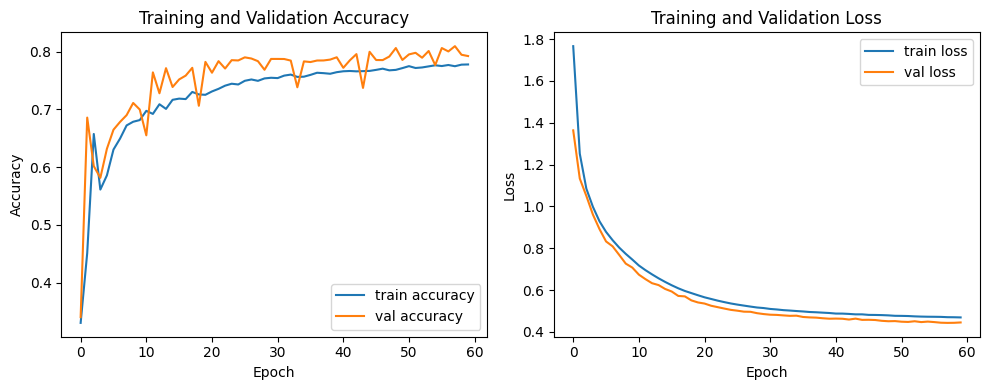

In [19]:
# Plot Accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'], label='train accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'], label='train loss')
plt.plot(history_transfer.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Transfer Learning Freeze layer ke 0-4

In [17]:
# 1. Load model hasil training binary classification
model_bin = build_mini_vgg(input_shape=(256,256,4))
model_bin.load_weights('/kaggle/input/minivgg256/tensorflow2/default/1/mini_vgg_256_hp.keras')

# 2. Panggil dummy input agar .input dan .output terbentuk
dummy_input = tf.zeros((1, 256, 256, 4))
_ = model_bin(dummy_input)

# 3. Bekukan layer Conv2D sampai conv2d_4
for layer in model_bin.layers[:7]:
    layer.trainable = False

# 4. Ambil input & output feature extractor secara aman
base_input = model_bin.layers[0].input            # input layer
base_output = model_bin.layers[-3].output         # output GlobalAveragePooling2D

# 5. Tambahkan head baru untuk klasifikasi payload
dense1 = Dense(128, activation='relu')(base_output)
final_output = Dense(6, activation='softmax')(dense1)

# 6. Bangun model baru
model_cs_transfer = Model(inputs=base_input, outputs=final_output)

# 7. Kompilasi model
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cs_transfer.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 256, 256, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,582 (1.16 MB)

 Trainable params: 164,870 (644.02 KB)

 Non-trainable params: 139,712 (545.75 KB)

In [18]:
# Kompilasi
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cbs_transfer = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8, verbose=1),
    ModelCheckpoint('mini_vgg_tl_031025_freeze_0-4.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

Epoch 1/60
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.1696 - loss: 4.7250
Epoch 1: val_loss improved from inf to 1.43270, saving model to mini_vgg_tl_031025_freeze_0-4.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 96s 185ms/step - accuracy: 0.1697 - loss: 4.7221 - val_accuracy: 0.2550 - val_loss: 1.4327 - learning_rate: 1.0000e-05
Epoch 2/60
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.4029 - loss: 1.3747
Epoch 2: val_loss improved from 1.43270 to 1.11159, saving model to mini_vgg_tl_031025_freeze_0-4.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 92s 185ms/step - accuracy: 0.4032 - loss: 1.3745 - val_accuracy: 0.6360 - val_loss: 1.1116 - learning_rate: 1.0000e-05
Epoch 3/60
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.5341 - loss: 1.1251
Epoch 3: val_loss improved from 1.11159 to 0.97192, saving model to mini_vgg_tl_031025_freeze_0-4.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 178ms/step - accuracy: 0.5341 - loss: 1.1250 - val_accuracy: 0.5700 - val_loss: 0.9719 - learning_r

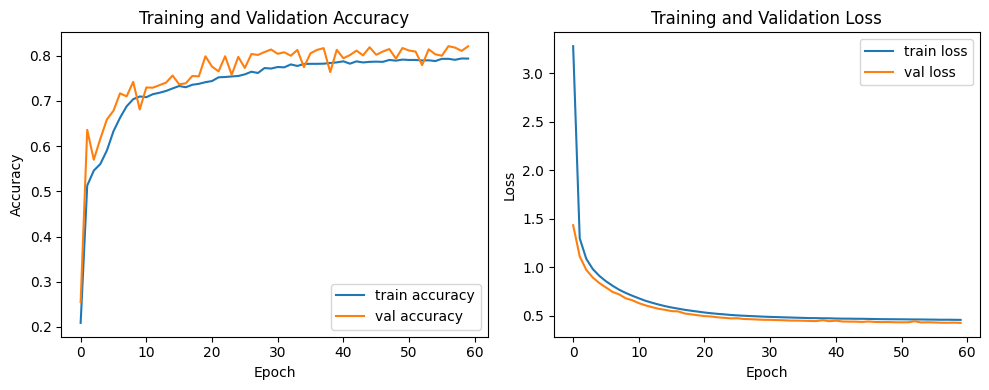

In [20]:
start = time.time()
history_transfer = model_cs_transfer.fit(
    train_ds_cs,               
    validation_data=val_ds_cs,
    epochs=60,
    batch_size=32,
    callbacks=cbs_transfer
)
end = time.time()

# Plot Accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'], label='train accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'], label='train loss')
plt.plot(history_transfer.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
duration = end - start
print(f"Training completed in {duration:.2f} seconds ({duration/60:.2f} minutes)")

Training completed in 5511.42 seconds (91.86 minutes)


# Transfer Learning Freeze layer ke 0-3

In [31]:
# 1. Load model hasil training binary classification
model_bin = build_mini_vgg(input_shape=(256,256,4))
model_bin.load_weights('/kaggle/input/minivgg256/tensorflow2/default/1/mini_vgg_256_hp.keras')

# 2. Panggil dummy input agar .input dan .output terbentuk
dummy_input = tf.zeros((1, 256, 256, 4))
_ = model_bin(dummy_input)

# 3. Bekukan layer Conv2D sampai conv2d_4
for layer in model_bin.layers[:6]:
    layer.trainable = False

# 4. Ambil input & output feature extractor secara aman
base_input = model_bin.layers[0].input            # input layer
base_output = model_bin.layers[-3].output         # output GlobalAveragePooling2D

# 5. Tambahkan head baru untuk klasifikasi payload
dense1 = Dense(128, activation='relu')(base_output)
final_output = Dense(6, activation='softmax')(dense1)

# 6. Bangun model baru
model_cs_transfer = Model(inputs=base_input, outputs=final_output)

# 7. Kompilasi model
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cs_transfer.summary()


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 256, 256, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 256, 256, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,582 (1.16 MB)

 Trainable params: 238,726 (932.52 KB)

 Non-trainable params: 65,856 (257.25 KB)

In [32]:
for i, layer in enumerate(model_cs_transfer.layers):
    print(f"{i}: {layer.name} → Trainable: {layer.trainable}")

0: input_layer_8 → Trainable: True
1: conv2d_48 → Trainable: False
2: conv2d_49 → Trainable: False
3: max_pooling2d_24 → Trainable: False
4: conv2d_50 → Trainable: False
5: conv2d_51 → Trainable: False
6: max_pooling2d_25 → Trainable: False
7: conv2d_52 → Trainable: True
8: conv2d_53 → Trainable: True
9: max_pooling2d_26 → Trainable: True
10: global_average_pooling2d_8 → Trainable: True
11: dense_34 → Trainable: True
12: dense_35 → Trainable: True


In [34]:
# Kompilasi
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cbs_transfer = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8, verbose=1),
    ModelCheckpoint('mini_vgg_tl_031025_freeze_0-3.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

Epoch 1/60

Epoch 1: val_loss improved from inf to 1.23800, saving model to mini_vgg_tl_031025_freeze_0-3.keras
500/500 - 98s - 195ms/step - accuracy: 0.2929 - loss: 1.6512 - val_accuracy: 0.4408 - val_loss: 1.2380 - learning_rate: 1.0000e-05
Epoch 2/60

Epoch 2: val_loss improved from 1.23800 to 0.98543, saving model to mini_vgg_tl_031025_freeze_0-3.keras
500/500 - 102s - 204ms/step - accuracy: 0.5132 - loss: 1.1128 - val_accuracy: 0.5181 - val_loss: 0.9854 - learning_rate: 1.0000e-05
Epoch 3/60

Epoch 3: val_loss improved from 0.98543 to 0.90190, saving model to mini_vgg_tl_031025_freeze_0-3.keras
500/500 - 90s - 180ms/step - accuracy: 0.5418 - loss: 0.9661 - val_accuracy: 0.5197 - val_loss: 0.9019 - learning_rate: 1.0000e-05
Epoch 4/60

Epoch 4: val_loss improved from 0.90190 to 0.83861, saving model to mini_vgg_tl_031025_freeze_0-3.keras
500/500 - 90s - 180ms/step - accuracy: 0.5700 - loss: 0.8923 - val_accuracy: 0.5692 - val_loss: 0.8386 - learning_rate: 1.0000e-05
Epoch 5/60

Epo

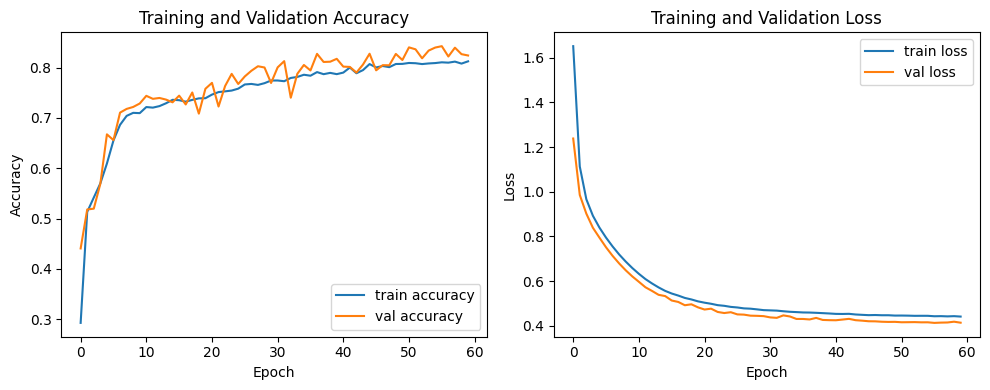

In [35]:
start = time.time()
history_transfer = model_cs_transfer.fit(
    train_ds_cs,               
    validation_data=val_ds_cs,
    epochs=60,
    batch_size=32,
    callbacks=cbs_transfer,
    verbose=2
)
end = time.time()

# Plot Accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'], label='train accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'], label='train loss')
plt.plot(history_transfer.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [39]:
duration = end - start
print(f"Training completed in {duration:.2f} seconds ({duration/60:.2f} minutes)")

Training completed in 5705.95 seconds (95.10 minutes)


# Transfer Learning Freeze layer ke 0-2

In [36]:
# 1. Load model hasil training binary classification
model_bin = build_mini_vgg(input_shape=(256,256,4))
model_bin.load_weights('/kaggle/input/minivgg256/tensorflow2/default/1/mini_vgg_256_hp.keras')

# 2. Panggil dummy input agar .input dan .output terbentuk
dummy_input = tf.zeros((1, 256, 256, 4))
_ = model_bin(dummy_input)

# 3. Bekukan layer Conv2D sampai conv2d_4
for layer in model_bin.layers[:4]:
    layer.trainable = False

# 4. Ambil input & output feature extractor secara aman
base_input = model_bin.layers[0].input            # input layer
base_output = model_bin.layers[-3].output         # output GlobalAveragePooling2D

# 5. Tambahkan head baru untuk klasifikasi payload
dense1 = Dense(128, activation='relu')(base_output)
final_output = Dense(6, activation='softmax')(dense1)

# 6. Bangun model baru
model_cs_transfer = Model(inputs=base_input, outputs=final_output)

# 7. Kompilasi model
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cs_transfer.summary()


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 256, 256, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 256, 256, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,582 (1.16 MB)

 Trainable params: 275,654 (1.05 MB)

 Non-trainable params: 28,928 (113.00 KB)

In [37]:
for i, layer in enumerate(model_cs_transfer.layers):
    print(f"{i}: {layer.name} → Trainable: {layer.trainable}")

0: input_layer_9 → Trainable: True
1: conv2d_54 → Trainable: False
2: conv2d_55 → Trainable: False
3: max_pooling2d_27 → Trainable: False
4: conv2d_56 → Trainable: False
5: conv2d_57 → Trainable: True
6: max_pooling2d_28 → Trainable: True
7: conv2d_58 → Trainable: True
8: conv2d_59 → Trainable: True
9: max_pooling2d_29 → Trainable: True
10: global_average_pooling2d_9 → Trainable: True
11: dense_38 → Trainable: True
12: dense_39 → Trainable: True


In [38]:
# Kompilasi
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cbs_transfer = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8, verbose=1),
    ModelCheckpoint('mini_vgg_tl_031025_freeze_0-2.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

Epoch 1/60

Epoch 1: val_loss improved from inf to 1.36623, saving model to mini_vgg_tl_031025_freeze_0-2.keras
500/500 - 99s - 197ms/step - accuracy: 0.2791 - loss: 2.8329 - val_accuracy: 0.4232 - val_loss: 1.3662 - learning_rate: 1.0000e-05
Epoch 2/60

Epoch 2: val_loss improved from 1.36623 to 1.00715, saving model to mini_vgg_tl_031025_freeze_0-2.keras
500/500 - 92s - 184ms/step - accuracy: 0.4945 - loss: 1.1571 - val_accuracy: 0.5520 - val_loss: 1.0072 - learning_rate: 1.0000e-05
Epoch 3/60

Epoch 3: val_loss improved from 1.00715 to 0.87712, saving model to mini_vgg_tl_031025_freeze_0-2.keras
500/500 - 92s - 183ms/step - accuracy: 0.5464 - loss: 0.9495 - val_accuracy: 0.5681 - val_loss: 0.8771 - learning_rate: 1.0000e-05
Epoch 4/60

Epoch 4: val_loss improved from 0.87712 to 0.80079, saving model to mini_vgg_tl_031025_freeze_0-2.keras
500/500 - 92s - 184ms/step - accuracy: 0.5903 - loss: 0.8543 - val_accuracy: 0.5847 - val_loss: 0.8008 - learning_rate: 1.0000e-05
Epoch 5/60

Epoc

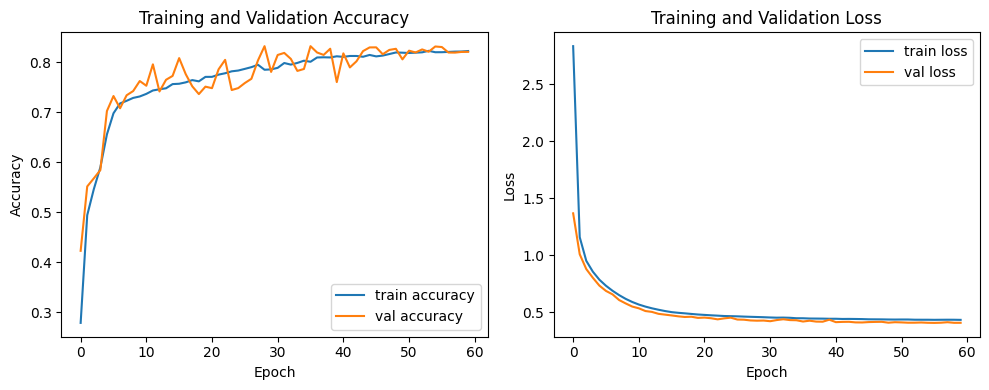

In [40]:
start = time.time()
history_transfer = model_cs_transfer.fit(
    train_ds_cs,               
    validation_data=val_ds_cs,
    epochs=60,
    batch_size=32,
    callbacks=cbs_transfer,
    verbose=2
)
end = time.time()
duration = end - start
print(f"Training completed in {duration:.2f} seconds ({duration/60:.2f} minutes)")

# Plot Accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'], label='train accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'], label='train loss')
plt.plot(history_transfer.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Transfer Learning Freeze layer ke 0-1

In [6]:
# 1. Load model hasil training binary classification
model_bin = build_mini_vgg(input_shape=(256,256,4))
model_bin.load_weights('/kaggle/input/minivgg256/tensorflow2/default/1/mini_vgg_256_hp.keras')

# 2. Panggil dummy input agar .input dan .output terbentuk
dummy_input = tf.zeros((1, 256, 256, 4))
_ = model_bin(dummy_input)

# 3. Bekukan layer Conv2D sampai conv2d_4
for layer in model_bin.layers[:3]:
    layer.trainable = False

# 4. Ambil input & output feature extractor secara aman
base_input = model_bin.layers[0].input            # input layer
base_output = model_bin.layers[-3].output         # output GlobalAveragePooling2D

# 5. Tambahkan head baru untuk klasifikasi payload
dense1 = Dense(128, activation='relu')(base_output)
final_output = Dense(6, activation='softmax')(dense1)

# 6. Bangun model baru
model_cs_transfer = Model(inputs=base_input, outputs=final_output)

# 7. Kompilasi model
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cs_transfer.summary()


I0000 00:00:1759541148.202601      36 cuda_dnn.cc:529] Loaded cuDNN version 90300


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,582 (1.16 MB)

 Trainable params: 294,150 (1.12 MB)

 Non-trainable params: 10,432 (40.75 KB)

In [7]:
for i, layer in enumerate(model_cs_transfer.layers):
    print(f"{i}: {layer.name} → Trainable: {layer.trainable}")

0: input_layer → Trainable: True
1: conv2d → Trainable: False
2: conv2d_1 → Trainable: False
3: max_pooling2d → Trainable: False
4: conv2d_2 → Trainable: True
5: conv2d_3 → Trainable: True
6: max_pooling2d_1 → Trainable: True
7: conv2d_4 → Trainable: True
8: conv2d_5 → Trainable: True
9: max_pooling2d_2 → Trainable: True
10: global_average_pooling2d → Trainable: True
11: dense_2 → Trainable: True
12: dense_3 → Trainable: True


In [8]:
# Kompilasi
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cbs_transfer = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8, verbose=1),
    ModelCheckpoint('mini_vgg_tl_031025_freeze_0-1.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

Epoch 1/60


I0000 00:00:1759541233.472060      72 service.cc:148] XLA service 0x7ef5b400dbf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759541233.472865      72 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759541240.042097      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 1.25312, saving model to mini_vgg_tl_031025_freeze_0-1.keras
500/500 - 123s - 246ms/step - accuracy: 0.2620 - loss: 3.0413 - val_accuracy: 0.4275 - val_loss: 1.2531 - learning_rate: 1.0000e-05
Epoch 2/60

Epoch 2: val_loss improved from 1.25312 to 0.98623, saving model to mini_vgg_tl_031025_freeze_0-1.keras
500/500 - 96s - 191ms/step - accuracy: 0.5050 - loss: 1.1312 - val_accuracy: 0.5361 - val_loss: 0.9862 - learning_rate: 1.0000e-05
Epoch 3/60

Epoch 3: val_loss improved from 0.98623 to 0.87374, saving model to mini_vgg_tl_031025_freeze_0-1.keras
500/500 - 95s - 190ms/step - accuracy: 0.5379 - loss: 0.9551 - val_accuracy: 0.5527 - val_loss: 0.8737 - learning_rate: 1.0000e-05
Epoch 4/60

Epoch 4: val_loss improved from 0.87374 to 0.80486, saving model to mini_vgg_tl_031025_freeze_0-1.keras
500/500 - 95s - 190ms/step - accuracy: 0.5660 - loss: 0.8673 - val_accuracy: 0.6146 - val_loss: 0.8049 - learning_rate: 1.0000e-05
Epoch 5/60

Epoch 5: val_l

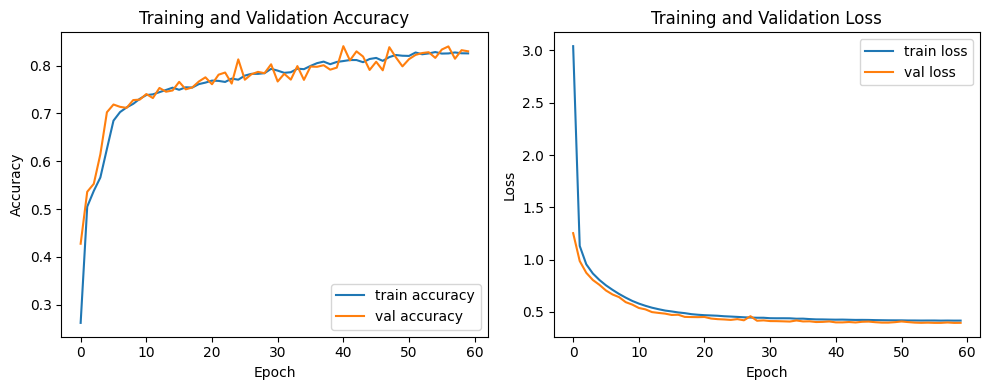

In [9]:
start = time.time()
history_transfer = model_cs_transfer.fit(
    train_ds_cs,               
    validation_data=val_ds_cs,
    epochs=60,
    batch_size=32,
    callbacks=cbs_transfer,
    verbose=2
)
end = time.time()
duration = end - start
print(f"Training completed in {duration:.2f} seconds ({duration/60:.2f} minutes)")

# Plot Accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'], label='train accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'], label='train loss')
plt.plot(history_transfer.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Transfer Learning Freeze layer ke 0

In [8]:
# 1. Load model hasil training binary classification
model_bin = build_mini_vgg(input_shape=(256,256,4))
model_bin.load_weights('/kaggle/input/minivgg256/tensorflow2/default/1/mini_vgg_256_hp.keras')

# 2. Panggil dummy input agar .input dan .output terbentuk
dummy_input = tf.zeros((1, 256, 256, 4))
_ = model_bin(dummy_input)

# 3. Bekukan layer Conv2D sampai conv2d_4
for layer in model_bin.layers[:1]:
    layer.trainable = False

# 4. Ambil input & output feature extractor secara aman
base_input = model_bin.layers[0].input            # input layer
base_output = model_bin.layers[-3].output         # output GlobalAveragePooling2D

# 5. Tambahkan head baru untuk klasifikasi payload
dense1 = Dense(128, activation='relu')(base_output)
final_output = Dense(6, activation='softmax')(dense1)

# 6. Bangun model baru
model_cs_transfer = Model(inputs=base_input, outputs=final_output)

# 7. Kompilasi model
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cs_transfer.summary()


I0000 00:00:1759547763.262245      36 cuda_dnn.cc:529] Loaded cuDNN version 90300


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,582 (1.16 MB)

 Trainable params: 303,398 (1.16 MB)

 Non-trainable params: 1,184 (4.62 KB)

In [9]:
for i, layer in enumerate(model_cs_transfer.layers):
    print(f"{i}: {layer.name} → Trainable: {layer.trainable}")

0: input_layer → Trainable: True
1: conv2d → Trainable: False
2: conv2d_1 → Trainable: True
3: max_pooling2d → Trainable: True
4: conv2d_2 → Trainable: True
5: conv2d_3 → Trainable: True
6: max_pooling2d_1 → Trainable: True
7: conv2d_4 → Trainable: True
8: conv2d_5 → Trainable: True
9: max_pooling2d_2 → Trainable: True
10: global_average_pooling2d → Trainable: True
11: dense_2 → Trainable: True
12: dense_3 → Trainable: True


In [10]:
# Kompilasi
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cbs_transfer = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8, verbose=1),
    ModelCheckpoint('mini_vgg_tl_031025_freeze_0.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

Epoch 1/60


I0000 00:00:1759547819.413143      72 service.cc:148] XLA service 0x7fb8b400e160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759547819.413848      72 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759547827.763784      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 1.61106, saving model to mini_vgg_tl_031025_freeze_0.keras
500/500 - 132s - 263ms/step - accuracy: 0.2994 - loss: 2.0569 - val_accuracy: 0.3058 - val_loss: 1.6111 - learning_rate: 1.0000e-05
Epoch 2/60

Epoch 2: val_loss improved from 1.61106 to 0.96935, saving model to mini_vgg_tl_031025_freeze_0.keras
500/500 - 92s - 184ms/step - accuracy: 0.4361 - loss: 1.2991 - val_accuracy: 0.5511 - val_loss: 0.9694 - learning_rate: 1.0000e-05
Epoch 3/60

Epoch 3: val_loss improved from 0.96935 to 0.83068, saving model to mini_vgg_tl_031025_freeze_0.keras
500/500 - 92s - 184ms/step - accuracy: 0.5729 - loss: 0.9043 - val_accuracy: 0.6784 - val_loss: 0.8307 - learning_rate: 1.0000e-05
Epoch 4/60

Epoch 4: val_loss improved from 0.83068 to 0.72238, saving model to mini_vgg_tl_031025_freeze_0.keras
500/500 - 92s - 183ms/step - accuracy: 0.6619 - loss: 0.7923 - val_accuracy: 0.7230 - val_loss: 0.7224 - learning_rate: 1.0000e-05
Epoch 5/60

Epoch 5: val_loss impr

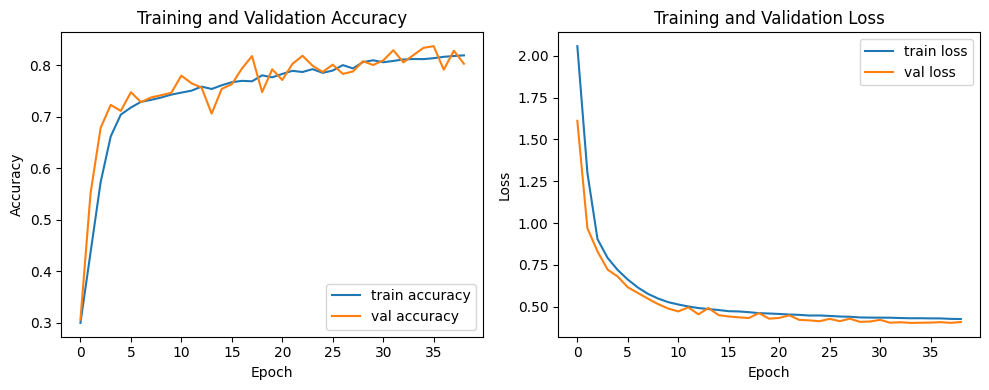

In [11]:
start = time.time()
history_transfer = model_cs_transfer.fit(
    train_ds_cs,               
    validation_data=val_ds_cs,
    epochs=60,
    batch_size=32,
    callbacks=cbs_transfer,
    verbose=2
)
end = time.time()
duration = end - start
print(f"Training completed in {duration:.2f} seconds ({duration/60:.2f} minutes)")

# Plot Accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'], label='train accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'], label='train loss')
plt.plot(history_transfer.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Transfer Learning unfreeze all

In [12]:
# 1. Load model hasil training binary classification
model_bin = build_mini_vgg(input_shape=(256,256,4))
model_bin.load_weights('/kaggle/input/minivgg256/tensorflow2/default/1/mini_vgg_256_hp.keras')

# 2. Panggil dummy input agar .input dan .output terbentuk
dummy_input = tf.zeros((1, 256, 256, 4))
_ = model_bin(dummy_input)

# 3. Ambil input & output feature extractor secara aman
base_input = model_bin.layers[0].input            # input layer
base_output = model_bin.layers[-3].output         # output GlobalAveragePooling2D

# 4. Tambahkan head baru untuk klasifikasi payload
dense1 = Dense(128, activation='relu')(base_output)
final_output = Dense(6, activation='softmax')(dense1)

# 5. Bangun model baru
model_cs_transfer = Model(inputs=base_input, outputs=final_output)

# 6. Kompilasi model
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cs_transfer.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,582 (1.16 MB)

 Trainable params: 304,582 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
for i, layer in enumerate(model_cs_transfer.layers):
    print(f"{i}: {layer.name} → Trainable: {layer.trainable}")

0: input_layer_1 → Trainable: True
1: conv2d_6 → Trainable: True
2: conv2d_7 → Trainable: True
3: max_pooling2d_3 → Trainable: True
4: conv2d_8 → Trainable: True
5: conv2d_9 → Trainable: True
6: max_pooling2d_4 → Trainable: True
7: conv2d_10 → Trainable: True
8: conv2d_11 → Trainable: True
9: max_pooling2d_5 → Trainable: True
10: global_average_pooling2d_1 → Trainable: True
11: dense_6 → Trainable: True
12: dense_7 → Trainable: True


In [14]:
# Kompilasi
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cbs_transfer = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8, verbose=1),
    ModelCheckpoint('mini_vgg_tl_031025_unfreeze_all.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

Epoch 1/60

Epoch 1: val_loss improved from inf to 1.15468, saving model to mini_vgg_tl_031025_unfreeze_all.keras
500/500 - 99s - 197ms/step - accuracy: 0.3945 - loss: 1.5970 - val_accuracy: 0.4963 - val_loss: 1.1547 - learning_rate: 1.0000e-05
Epoch 2/60

Epoch 2: val_loss improved from 1.15468 to 0.86518, saving model to mini_vgg_tl_031025_unfreeze_all.keras
500/500 - 93s - 186ms/step - accuracy: 0.5433 - loss: 0.9823 - val_accuracy: 0.6219 - val_loss: 0.8652 - learning_rate: 1.0000e-05
Epoch 3/60

Epoch 3: val_loss improved from 0.86518 to 0.77393, saving model to mini_vgg_tl_031025_unfreeze_all.keras
500/500 - 95s - 190ms/step - accuracy: 0.6036 - loss: 0.8422 - val_accuracy: 0.6478 - val_loss: 0.7739 - learning_rate: 1.0000e-05
Epoch 4/60

Epoch 4: val_loss improved from 0.77393 to 0.70947, saving model to mini_vgg_tl_031025_unfreeze_all.keras
500/500 - 96s - 191ms/step - accuracy: 0.6728 - loss: 0.7672 - val_accuracy: 0.7266 - val_loss: 0.7095 - learning_rate: 1.0000e-05
Epoch 5/

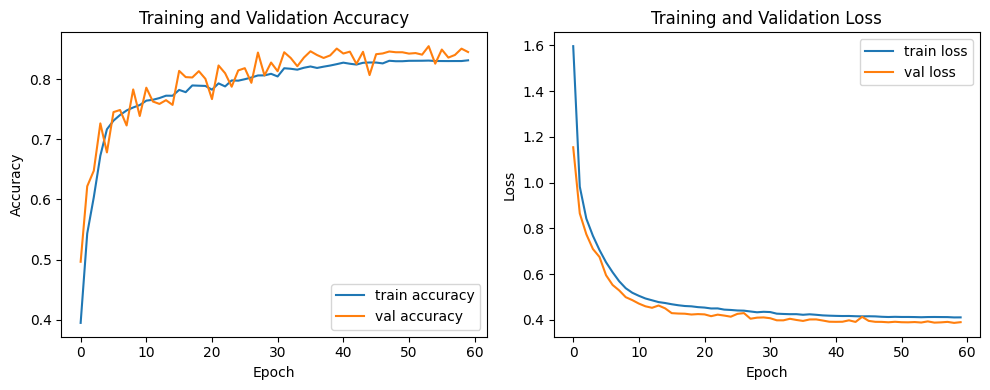

In [15]:
start = time.time()
history_transfer = model_cs_transfer.fit(
    train_ds_cs,               
    validation_data=val_ds_cs,
    epochs=60,
    batch_size=32,
    callbacks=cbs_transfer,
    verbose=2
)
end = time.time()
duration = end - start
print(f"Training completed in {duration:.2f} seconds ({duration/60:.2f} minutes)")

# Plot Accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'], label='train accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'], label='train loss')
plt.plot(history_transfer.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()